# Проект: классификация

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [83]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [84]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [85]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [86]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
#df['job'].isna().sum()
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [87]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# #df['balance'] = df['balance'].map(lambda x: float(x))
# print(df['balance'].str.replace('[ $]', ''))
# df['balance'] = df['balance'].str.replace(',', '.').str.replace('[ $]', '').astype(float)
# df['balance'] = df['balance'].str.strip().str.replace('[ $]', '').str.replace(',', '.').astype(float)
# df['balance'] = df['balance'].str.replace('[ $]', '').str.replace(',', '.').astype(float)
#     num = re.sub('[^0-9\.]', '', value)
    # Преобразуем полученную строку в тип float
    # return float(num)
# df['balance'] = df['balance'].str.replace(',', '.')  # заменяем запятые на точки
df['balance'] = df['balance'].str.replace(',', '.').str.extract('(\d+\.\d+)').astype(float)  # извлекаем числа и преобразуем в тип float

df['balance']

0        343.0
1         45.0
2        270.0
3        476.0
4        184.0
         ...  
11157      1.0
11158    733.0
11159     29.0
11160      NaN
11161      NaN
Name: balance, Length: 11162, dtype: float64

In [88]:
df['balance'].mean()

400.256875422175

### Задание 4

In [89]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].mean()


396.65938003941943

### Задание 5

In [90]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df.loc[df['job'] == 'unknown', 'job'] = 'management'

In [91]:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'self-employed', 'student'], dtype=object)

In [92]:
df.loc[df['education'] == 'unknown', 'education'] = 'secondary'

In [93]:
df['education'].unique()

array(['secondary', 'tertiary', 'primary'], dtype=object)

In [94]:
df['job']

0             admin.
1             admin.
2         technician
3           services
4             admin.
            ...     
11157    blue-collar
11158       services
11159     technician
11160     technician
11161     technician
Name: job, Length: 11162, dtype: object

In [95]:
# df[(df['job'] == 'management') & (df['education'] == 'secondary')].mean()['balance']
df[(df['job'] == 'management') & (df['education'] == 'secondary')]['balance'].mean()

412.6968085106383

### Задание 6

In [96]:
df['balance'].describe()

count    11162.000000
mean       396.659380
std        274.210812
min          0.000000
25%        167.000000
50%        350.000000
75%        597.000000
max        999.000000
Name: balance, dtype: float64

In [97]:
q_75, q_25 = np.percentile(df['balance'], [75 ,25])
iqr = q_75 - q_25
min_bound = q_25 - 1.5*iqr 
max_bound = q_75 + 1.5*iqr 

In [98]:
min_bound

-478.0

In [99]:
max_bound

1242.0

In [100]:
iqr

430.0

In [101]:
df.drop(df[df['balance'] < min_bound].index | df[df['balance'] > max_bound].index, inplace=True)

In [102]:
min_bound

-478.0

In [103]:
max_bound

1242.0

In [104]:
iqr

430.0

In [105]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,396.659380,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,274.210812,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,0.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,167.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,350.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,597.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,999.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [106]:
df['balance'].describe()

count    11162.000000
mean       396.659380
std        274.210812
min          0.000000
25%        167.000000
50%        350.000000
75%        597.000000
max        999.000000
Name: balance, dtype: float64

## Часть 2:  Разведывательный анализ

### Задание 1

In [107]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

### Задания 2 и 3

In [108]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
barplot = df['deposit'].value_counts()

In [109]:
y = ['yes', 'no']
x = [5424, 4681]

<AxesSubplot: >

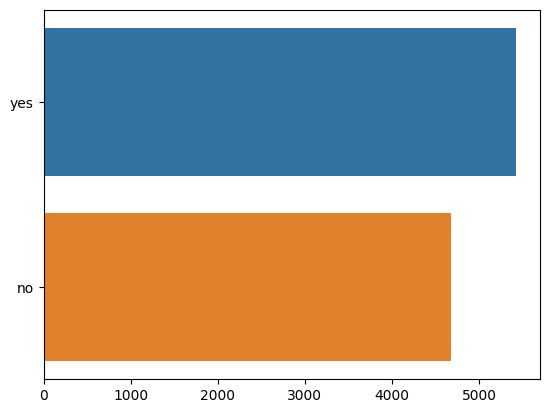

In [110]:
sns.barplot(x=x, y=y)

### Задания 4 и 5

In [111]:
df['age'].max()

95

In [112]:
df['duration'].min()

2

In [113]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [114]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df['job'].describe()

count          11162
unique            11
top       management
freq            2636
Name: job, dtype: object

Text(0.5, 1.0, 'Type of Job')

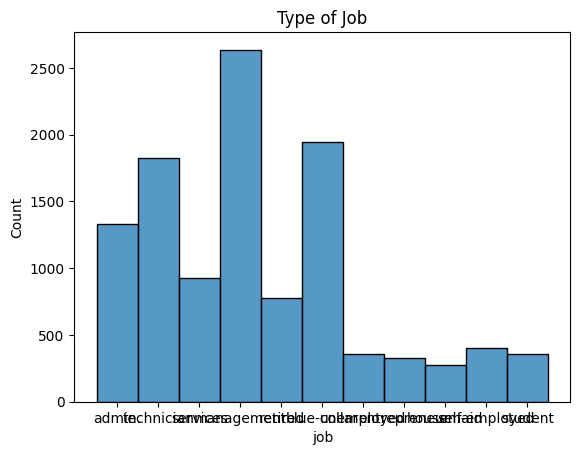

In [115]:
sns.histplot(df['job'], legend=True).set_title('Type of Job')

Text(0.5, 1.0, 'Type of education')

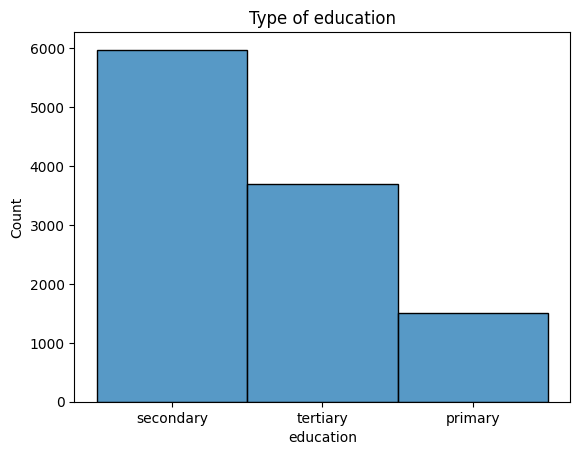

In [116]:
sns.histplot(df['education'], legend=True).set_title('Type of education')

Text(0.5, 1.0, 'Type of marital')

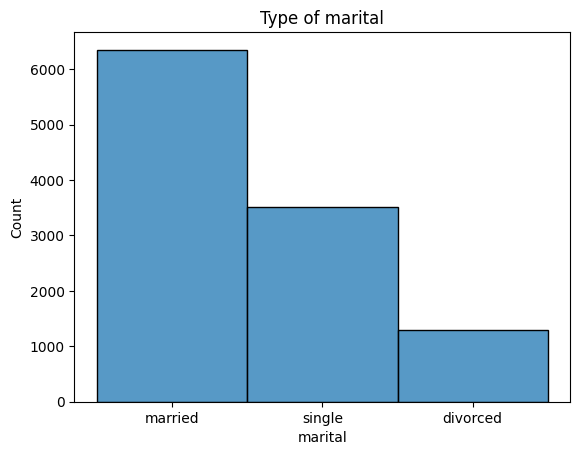

In [117]:
sns.histplot(df['marital'], legend=True).set_title('Type of marital')


Text(0.5, 1.0, 'Налииче ипотеки')

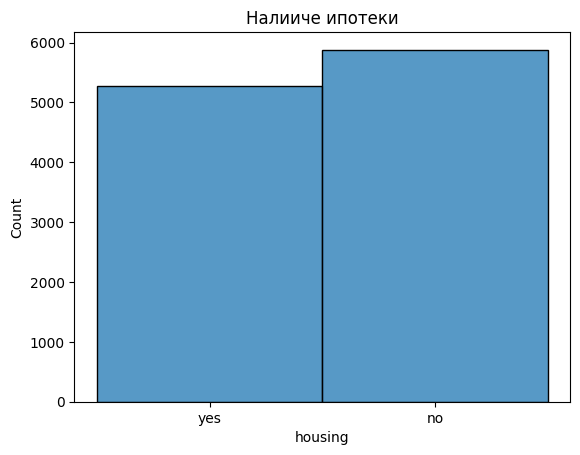

In [118]:
sns.histplot(df['housing'], legend=True).set_title('Налииче ипотеки')

Text(0.5, 1.0, 'Налииче потребительского кредита')

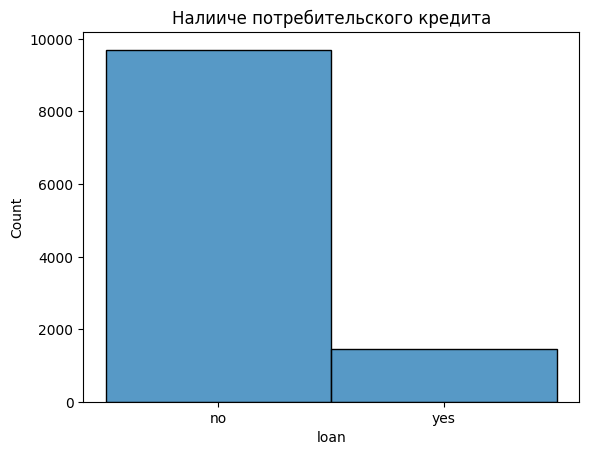

In [119]:
sns.histplot(df['loan'], legend=True).set_title('Налииче потребительского кредита')

Text(0.5, 1.0, 'Распределение по типам контактов с клиентом')

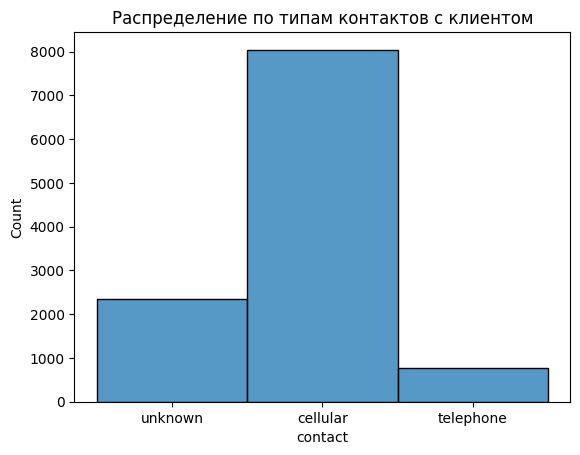

In [120]:
sns.histplot(df['contact'], legend=True).set_title('Распределение по типам контактов с клиентом')

Text(0.5, 1.0, 'Распределение контактов с клиентом по месяцам')

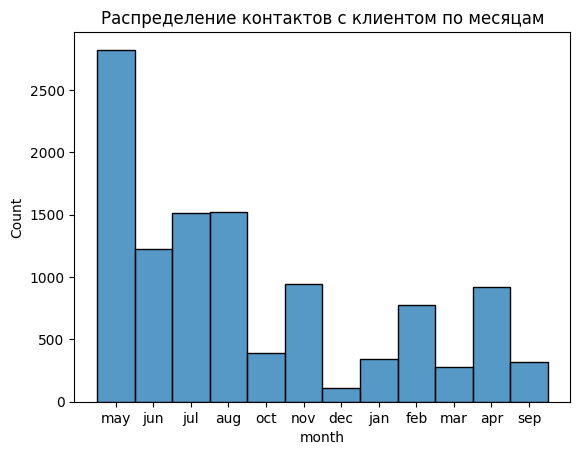

In [121]:
sns.histplot(df['month'], legend=True).set_title('Распределение контактов с клиентом по месяцам')

Text(0.5, 1.0, 'Распределение контактов с клиентом в текущей компании')

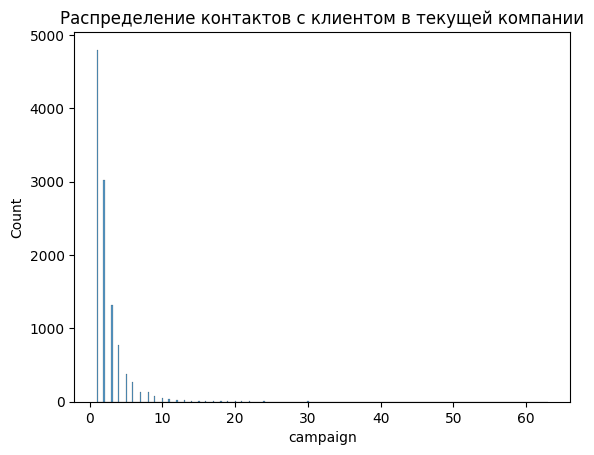

In [122]:
sns.histplot(df['campaign'], legend=True).set_title('Распределение контактов с клиентом в текущей компании')

Text(0.5, 1.0, 'Распределение результатов в прошлой маркетинговой компании')

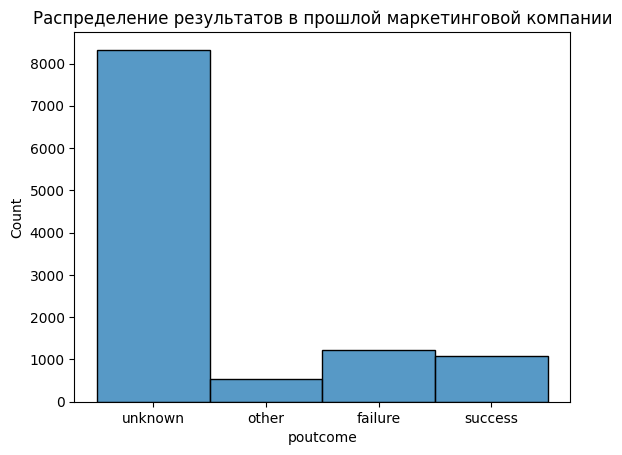

In [123]:
sns.histplot(df['poutcome'], legend=True).set_title('Распределение результатов в прошлой маркетинговой компании')

In [124]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2636,6351,5973,10994,5881,9702,8042,2824,8326,5873


### Задание 6

In [125]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df['poutcome'].value_counts()

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

### Задание 7

In [126]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
df['month'][(df['deposit'] == 'no')].value_counts()
#df[(df['job'] == 'management') & (df['education'] == 'secondary')].mean()['balance']

may    1899
jul     887
aug     831
jun     676
nov     540
apr     346
feb     335
jan     202
oct      69
sep      50
mar      28
dec      10
Name: month, dtype: int64

### Задание 8

In [127]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Задаем границы и метки для разделения на возрастные группы
bins = [0, 29, 40, 50, 60, 100]
labels = ['<30', '30-40', '40-50', '50-60', '60+']
# Создаем колонку age-group, разделяя возраст на группы с помощью pd.cut
df['age-group'] = pd.cut(df['age'], bins, labels = labels, include_lowest=True)

In [128]:
# Группируем DataFrame по колонке age-group, выбиарем колонку deposit и выводим количество записей в каждой группе
# при этом, мы делаем нормализацию (получаем процентное соотношение yes к всему набору и no к всему набору)
# а так же применяем функцию mul, чтобы умножить проценты на 100 для более удобочитаемого вида
grouped = df.groupby('age-group')['deposit'].value_counts(normalize=True).mul(100)

In [129]:
# Сортируем по убыванию
sorted_grouped = grouped.sort_values(ascending=False)

In [130]:
sorted_grouped

age-group  deposit
60+        yes        82.160393
<30        yes        59.832366
40-50      no         59.174679
50-60      no         56.397849
30-40      no         56.309216
           yes        43.690784
50-60      yes        43.602151
40-50      yes        40.825321
<30        no         40.167634
60+        no         17.839607
Name: deposit, dtype: float64

### Задания 9 и 10

In [131]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
grouped_marital = df.groupby('marital')['deposit'].value_counts(normalize=True).mul(100)
grouped_marital

marital   deposit
divorced  no         51.894818
          yes        48.105182
married   no         56.621005
          yes        43.378995
single    yes        54.349062
          no         45.650938
Name: deposit, dtype: float64

In [132]:
df_gm = pd.DataFrame(data=grouped_marital)
df_gm = df_gm.rename(columns={'deposit': 'percentage'})

In [133]:
df_gm

percentage
marital  deposit            
divorced no        51.894818
         yes       48.105182
married  no        56.621005
         yes       43.378995
single   yes       54.349062
         no        45.650938

In [134]:
dist_df = df_gm.reset_index()
dist_df

,marital,deposit,percentage
0,divorced,no,51.894818
1,divorced,yes,48.105182
2,married,no,56.621005
3,married,yes,43.378995
4,single,yes,54.349062
5,single,no,45.650938


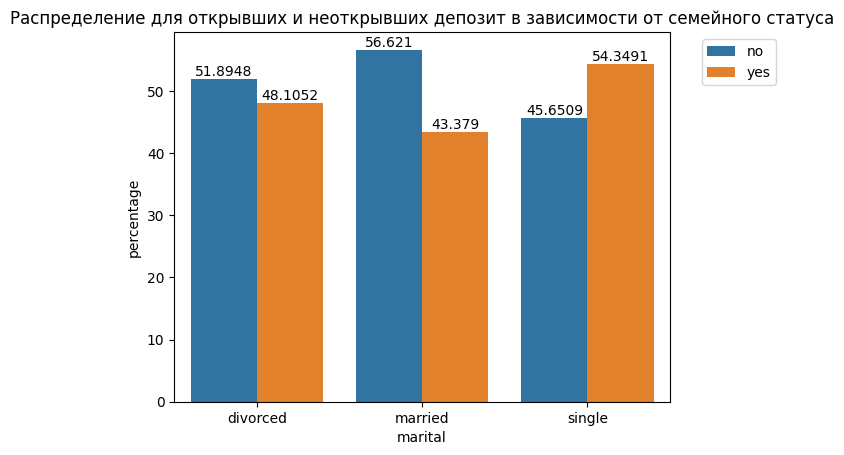

In [135]:
ax = sns.barplot(data = dist_df, x='marital', y='percentage', hue='deposit')
for i in ax.containers:
    ax.bar_label(i)
ax.set_title('Распределение для открывших и неоткрывших депозит в зависимости от семейного статуса')
plt.legend(bbox_to_anchor=(1.05, 1))


In [136]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
grouped_education = df.groupby('education')['deposit'].value_counts(normalize=True).mul(100)
grouped_education

education  deposit
primary    no         60.600000
           yes        39.400000
secondary  no         54.763101
           yes        45.236899
tertiary   yes        54.106804
           no         45.893196
Name: deposit, dtype: float64

In [137]:
df_ed = pd.DataFrame(data=grouped_education)
df_ed = df_ed.rename(columns={'deposit': 'percentage'})
df_ed = df_ed.reset_index()
df_ed

,education,deposit,percentage
0,primary,no,60.600000
1,primary,yes,39.400000
2,secondary,no,54.763101
3,secondary,yes,45.236899
4,tertiary,yes,54.106804
5,tertiary,no,45.893196


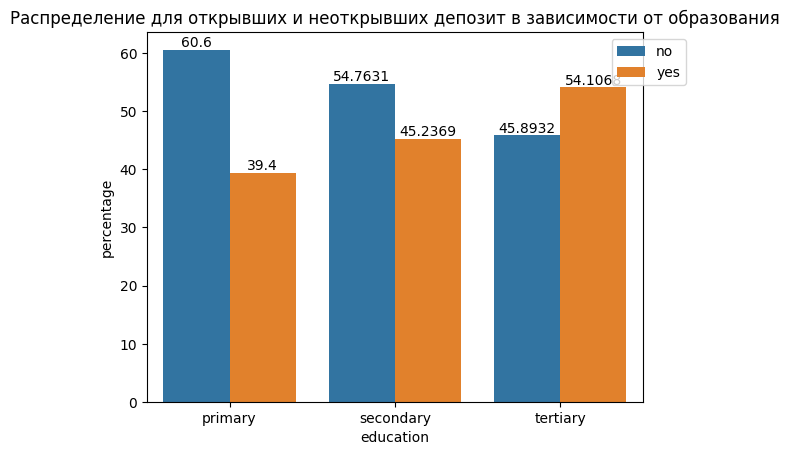

In [138]:
ax = sns.barplot(data = df_ed, x='education', y='percentage', hue='deposit')
for i in ax.containers:
    ax.bar_label(i)
ax.set_title('Распределение для открывших и неоткрывших депозит в зависимости от образования')
plt.legend(bbox_to_anchor=(1.1, 1))

In [139]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
grouped_job = df.groupby('job')['deposit'].value_counts(normalize=True).mul(100)
grouped_job

job            deposit
admin.         no         52.698651
               yes        47.301349
blue-collar    no         63.580247
               yes        36.419753
entrepreneur   no         62.500000
               yes        37.500000
housemaid      no         60.218978
               yes        39.781022
management     yes        50.644917
               no         49.355083
retired        yes        66.323907
               no         33.676093
self-employed  no         53.827160
               yes        46.172840
services       no         60.021668
               yes        39.978332
student        yes        74.722222
               no         25.277778
technician     no         53.922106
               yes        46.077894
unemployed     yes        56.582633
               no         43.417367
Name: deposit, dtype: float64

In [140]:
df_job = pd.DataFrame(data=grouped_job)
df_job = df_job.rename(columns={'deposit': 'percentage'})
df_job = df_job.reset_index()
df_job

,job,deposit,percentage
0,admin.,no,52.698651
1,admin.,yes,47.301349
2,blue-collar,no,63.580247
3,blue-collar,yes,36.419753
4,entrepreneur,no,62.500000
5,entrepreneur,yes,37.500000
6,housemaid,no,60.218978
7,housemaid,yes,39.781022
8,management,yes,50.644917
9,management,no,49.355083


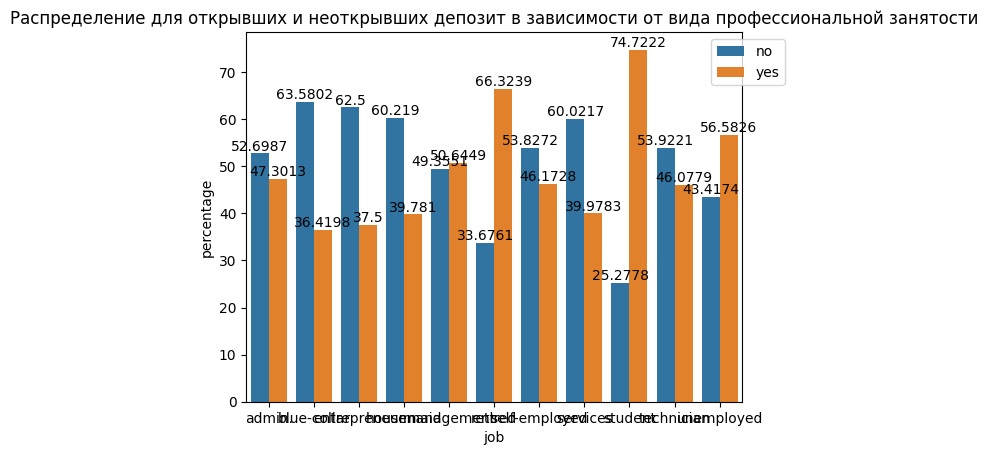

In [141]:
ax = sns.barplot(data = df_job, x='job', y='percentage', hue='deposit')
for i in ax.containers:
    ax.bar_label(i)
ax.set_title('Распределение для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости')
plt.legend(bbox_to_anchor=(1.1, 1))

### Задание 11

In [142]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_deposit_yes = df[df['deposit']=='yes']
df_deposit_yes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5289 entries, 0 to 5288
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        5289 non-null   int64   
 1   job        5289 non-null   object  
 2   marital    5289 non-null   object  
 3   education  5289 non-null   object  
 4   default    5289 non-null   object  
 5   balance    5289 non-null   float64 
 6   housing    5289 non-null   object  
 7   loan       5289 non-null   object  
 8   contact    5289 non-null   object  
 9   day        5289 non-null   int64   
 10  month      5289 non-null   object  
 11  duration   5289 non-null   int64   
 12  campaign   5289 non-null   int64   
 13  pdays      5289 non-null   int64   
 14  previous   5289 non-null   int64   
 15  poutcome   5289 non-null   object  
 16  deposit    5289 non-null   object  
 17  age-group  5289 non-null   category
dtypes: category(1), float64(1), int64(6), object(10)
memory usage: 749.1

In [143]:
grouped_mar_edu_yes = df_deposit_yes.groupby('marital')['education'].value_counts()
grouped_mar_edu_yes

marital   education
divorced  secondary     315
          tertiary      203
          primary       104
married   secondary    1446
          tertiary      913
          primary       396
single    secondary     941
          tertiary      880
          primary        91
Name: education, dtype: int64

## Часть 3: преобразование данных

### Задание 1

In [144]:
# преобразуйте уровни образования
le = preprocessing.LabelEncoder()
le.fit_transform(df['education']).sum()


13351

In [145]:
df['education'] = le.fit_transform(df['education'])

In [146]:
df['education']

0        1
1        1
2        1
3        1
4        2
        ..
11157    0
11158    1
11159    1
11160    1
11161    1
Name: education, Length: 11162, dtype: int32

### Задания 2 и 3

In [147]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age-group
0,59,admin.,married,1,no,343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,1,no,270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,1,no,476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


In [148]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' or x == 1 else 0)

In [149]:
df['deposit'].std()

0.4993375439121514

In [150]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age-group
0,59,admin.,married,1,no,343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,50-60
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,1,50-60
2,41,technician,married,1,no,270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,40-50
3,55,services,married,1,no,476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,1,50-60
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,1,50-60


In [151]:
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' or x == 1 else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' or x == 1 else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' or x == 1 else 0)

In [152]:
a = df['default'].apply(lambda x: 1 if x == 'yes' or x == 1 else 0).mean()
b = df['housing'].apply(lambda x: 1 if x == 'yes' or x == 1 else 0).mean()
c = df['loan'].apply(lambda x: 1 if x == 'yes' or x == 1 else 0).mean()
d = a + b + c
d

0.6189750940691633

In [153]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age-group
0,59,admin.,married,1,0,343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,50-60
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,50-60
2,41,technician,married,1,0,270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,40-50
3,55,services,married,1,0,476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,50-60
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,50-60


### Задание 4

In [154]:
# создайте дамми-переменные
df = pd.get_dummies (df, columns=['job', 'marital', 'contact', 'month', 'poutcome', 'age-group'])

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                11162 non-null  int64  
 1   education          11162 non-null  int32  
 2   default            11162 non-null  int64  
 3   balance            11162 non-null  float64
 4   housing            11162 non-null  int64  
 5   loan               11162 non-null  int64  
 6   day                11162 non-null  int64  
 7   duration           11162 non-null  int64  
 8   campaign           11162 non-null  int64  
 9   pdays              11162 non-null  int64  
 10  previous           11162 non-null  int64  
 11  deposit            11162 non-null  int64  
 12  job_admin.         11162 non-null  uint8  
 13  job_blue-collar    11162 non-null  uint8  
 14  job_entrepreneur   11162 non-null  uint8  
 15  job_housemaid      11162 non-null  uint8  
 16  job_management     111

### Задания 5 и 6

<AxesSubplot: >

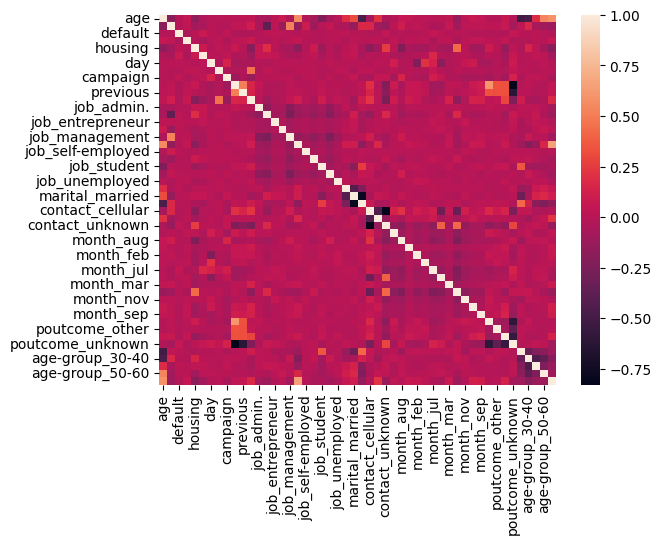

In [156]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
sns.heatmap(df.corr())

In [157]:
df.corr().sort_index(axis=1)

,age,age-group_30-40,age-group_40-50,age-group_50-60,age-group_60+,age-group_<30,balance,campaign,contact_cellular,contact_telephone,...,month_may,month_nov,month_oct,month_sep,pdays,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,previous
age,1.000000,-0.469886,0.179264,0.529255,0.582844,-0.499838,0.056368,-0.005278,-0.085019,0.210912,...,-0.122287,0.020910,0.067004,0.040306,0.002774,-0.008071,-0.018715,0.062114,-0.027021,0.020169
education,-0.193752,0.160118,-0.070626,-0.095636,-0.113886,0.034837,0.030991,-0.014311,0.170551,-0.081436,...,-0.099668,0.028645,0.028414,0.031652,0.029816,0.022438,0.018392,0.068925,-0.071798,0.033255
default,-0.011425,-0.014775,0.027253,-0.003939,-0.026513,0.009904,-0.049835,0.030975,-0.026301,-0.022157,...,-0.000853,-0.000511,-0.023584,-0.016787,-0.036282,-0.024650,-0.017475,-0.040272,0.053554,-0.035273
balance,0.056368,-0.016782,0.003011,0.006559,0.062310,-0.027755,1.000000,-0.033420,0.009240,0.024158,...,-0.053001,0.019121,0.040226,0.038991,0.019913,0.016536,-0.003530,0.043937,-0.039875,0.035343
housing,-0.168700,0.146279,0.032766,-0.087159,-0.190173,-0.028954,-0.019549,0.006660,-0.181475,-0.088433,...,0.427163,0.013449,-0.095006,-0.087152,0.064497,0.087741,0.010006,-0.136299,0.024227,-0.000840
loan,-0.031418,0.000841,0.032854,0.020470,-0.082839,-0.008351,-0.052914,0.034722,-0.000534,-0.020123,...,0.005878,0.014001,-0.032150,-0.045807,-0.030416,0.006264,-0.020164,-0.080370,0.059783,-0.022668
day,-0.000762,0.003153,-0.000165,0.015962,-0.014128,-0.012200,-0.004354,0.137007,-0.011402,0.014687,...,-0.010188,0.062185,0.079939,-0.072279,-0.077232,-0.068381,-0.007526,-0.044280,0.082807,-0.058981
duration,0.000189,0.006843,-0.009628,-0.004808,0.003256,0.004884,0.021784,-0.041557,0.020938,-0.015966,...,0.010680,-0.007683,-0.013847,-0.010389,-0.027392,-0.033966,-0.008782,-0.022578,0.044006,-0.026716
campaign,-0.005278,0.019892,0.028831,0.012042,-0.053630,-0.040780,-0.033420,1.000000,-0.067236,0.046576,...,-0.038520,-0.077215,-0.069786,-0.049224,-0.102726,-0.080188,-0.023689,-0.091807,0.131392,-0.049699
pdays,0.002774,0.021465,-0.016370,-0.024484,0.029226,-0.003712,0.019913,-0.102726,0.205877,0.006710,...,0.026120,-0.011859,0.074312,0.104793,1.000000,0.602615,0.341404,0.329567,-0.823928,0.507272


<AxesSubplot: >

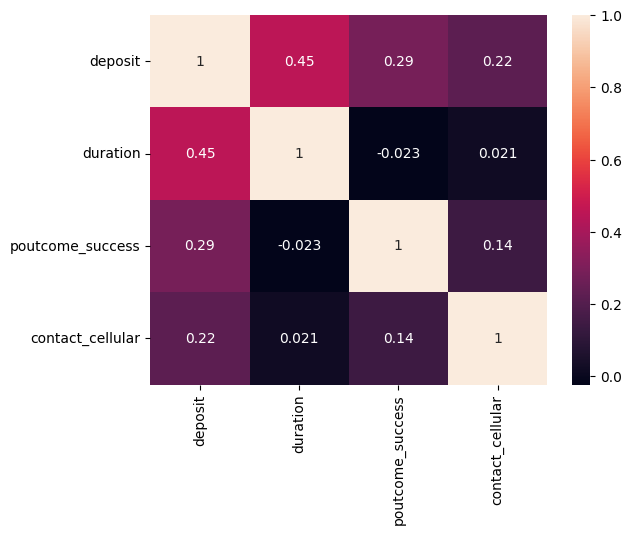

In [158]:
sns.heatmap(df[['deposit', 'duration','poutcome_success', 'contact_cellular']].corr(), annot=True)

### Задания 7 и 8

In [159]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [160]:
# рассчитайте необходимые показатели
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3684 entries, 6029 to 10200
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3684 non-null   int64  
 1   education          3684 non-null   int32  
 2   default            3684 non-null   int64  
 3   balance            3684 non-null   float64
 4   housing            3684 non-null   int64  
 5   loan               3684 non-null   int64  
 6   day                3684 non-null   int64  
 7   duration           3684 non-null   int64  
 8   campaign           3684 non-null   int64  
 9   pdays              3684 non-null   int64  
 10  previous           3684 non-null   int64  
 11  job_admin.         3684 non-null   uint8  
 12  job_blue-collar    3684 non-null   uint8  
 13  job_entrepreneur   3684 non-null   uint8  
 14  job_housemaid      3684 non-null   uint8  
 15  job_management     3684 non-null   uint8  
 16  job_retired        3

In [161]:
y_test.mean()

0.4739413680781759

### Задание 9

In [162]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
X_train_new = SelectKBest(score_func = f_classif, k=15).fit(X_train, y_train)

In [163]:
X_train_new.get_feature_names_out()

array(['housing', 'loan', 'duration', 'campaign', 'pdays', 'previous',
       'contact_cellular', 'contact_unknown', 'month_mar', 'month_may',
       'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown',
       'age-group_60+'], dtype=object)

### Задание 10

In [164]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# X_train_normalized = scaler.fit_transform(X_train)
# X_test_normalized = scaler.fit_transform(X_test)

X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_normalized = pd.DataFrame(scaler.fit_transform(X_test), columns=X_train.columns, index=X_test.index)

# len(X_test_normalized.T[0])
# X_train_normalized[:, 0].mean()
# X_test_normalized[:, 0].mean()
# X_test
# X_test['age']
#X_test_normalized
# X_test
# X_test_normalized['balance'].mean()
X_test_normalized['age'].mean()

0.30498681557313473

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [165]:
# обучите логистическую регрессию и рассчитайте метрики качества
lr = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
lr.fit(X_train_normalized, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [166]:
y_pred = lr.predict(X_test_normalized)

In [167]:
from sklearn.metrics import accuracy_score
print('Accuracy score: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy score: 0.808


### Задания 2,3,4

In [168]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=10)
dt.fit(X_train_normalized, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [169]:
y_pred = dt.predict(X_test_normalized)

In [170]:
print('Accuracy score: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy score: 0.815


### Задание 5

In [171]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import RandomizedSearchCV
param_distributions = {
                'min_samples_leaf': [2, 5, 7, 10],
                'max_depth': [3, 5, 7]
              }
            
random_search_rf = RandomizedSearchCV(tree.DecisionTreeClassifier(random_state=42), 
                                          param_distributions, cv=5, n_iter = 10, n_jobs = -1)  
random_search_rf.fit(X_train_normalized, y_train)
%time random_search_rf.fit(X_train_normalized, y_train) 
y_train_pred = random_search_rf.predict(X_train_normalized)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_rf.score(X_test_normalized, y_test)))
y_test_pred = random_search_rf.predict(X_test_normalized)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_rf.best_params_))

CPU times: total: 172 ms
Wall time: 892 ms
f1_score на обучающем наборе: 0.83
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'min_samples_leaf': 10, 'max_depth': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [172]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', min_samples_leaf = 5, max_depth = 10, random_state = 42)
rf.fit(X_train_normalized, y_train)
y_pred = rf.predict(X_test_normalized)
print("accuracy на тестовом наборе: {:.2f}".format(metrics.accuracy_score(y_pred, y_test)))
print("recall на тестовом наборе: {:.2f}".format(metrics.recall_score(y_pred, y_test)))

accuracy на тестовом наборе: 0.84
recall на тестовом наборе: 0.85


### Задания 2 и 3

In [173]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 300, min_samples_leaf = 5, max_depth = 5, random_state = 42)
gb.fit(X_train_normalized, y_train)
y_pred = gb.predict(X_test_normalized)
print("accuracy на тестовом наборе: {:.2f}".format(metrics.accuracy_score(y_pred, y_test)))
print("recall на тестовом наборе: {:.2f}".format(metrics.recall_score(y_pred, y_test)))

accuracy на тестовом наборе: 0.86
recall на тестовом наборе: 0.86


### Задание 4

In [174]:
from sklearn.ensemble import StackingClassifier

# объедините уже известные вам алгоритмы с помощью стекинга
estimators = [('rf', rf), ('gb', gb)]
clf = StackingClassifier(estimators=estimators)
clf.fit(X_train, y_train).score(X_test, y_test)

0.8612920738327905

### Задание 5

In [175]:
importances = pd.DataFrame({
    'feature': X.columns,
    'importance_rf': clf.named_estimators_['rf'].feature_importances_,
    'importance_gb': clf.named_estimators_['gb'].feature_importances_
}).sort_values(['importance_rf', 'importance_gb'], ascending=False)

# Выведем на печать 10 наиболее важных признаков
print(importances.head(10))

             feature  importance_rf  importance_gb
7           duration       0.444616       0.441547
42  poutcome_success       0.080091       0.085535
27   contact_unknown       0.045641       0.070484
0                age       0.040705       0.036847
9              pdays       0.034285       0.050405
25  contact_cellular       0.033728       0.002365
4            housing       0.031018       0.039521
6                day       0.025009       0.046117
3            balance       0.022245       0.025009
10          previous       0.021834       0.005419


In [176]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
importances = pd.DataFrame({
    'feature': X.columns,
    'importance_gb': clf.named_estimators_['gb'].feature_importances_
}).sort_values('importance_gb', ascending=False)

# Выведем на печать 10 наиболее важных признаков
print(importances.head(10))

             feature  importance_gb
7           duration       0.441547
42  poutcome_success       0.085535
27   contact_unknown       0.070484
9              pdays       0.050405
6                day       0.046117
4            housing       0.039521
0                age       0.036847
35         month_mar       0.026433
3            balance       0.025009
28         month_apr       0.021250


### Задания 6,7,8

In [177]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

In [178]:
!!pip install optuna

['Requirement already satisfied: optuna in c:\\users\\iomishchenko\\appdata\\local\\programs\\python\\python39\\lib\\site-packages (3.1.0)',
 'Requirement already satisfied: packaging>=20.0 in c:\\users\\iomishchenko\\appdata\\local\\programs\\python\\python39\\lib\\site-packages (from optuna) (21.3)',
 'Requirement already satisfied: alembic>=1.5.0 in c:\\users\\iomishchenko\\appdata\\local\\programs\\python\\python39\\lib\\site-packages (from optuna) (1.9.2)',
 'Requirement already satisfied: numpy in c:\\users\\iomishchenko\\appdata\\local\\programs\\python\\python39\\lib\\site-packages (from optuna) (1.23.2)',
 'Requirement already satisfied: colorlog in c:\\users\\iomishchenko\\appdata\\local\\programs\\python\\python39\\lib\\site-packages (from optuna) (6.7.0)',
 'Requirement already satisfied: cmaes>=0.9.1 in c:\\users\\iomishchenko\\appdata\\local\\programs\\python\\python39\\lib\\site-packages (from optuna) (0.9.1)',
 'Requirement already satisfied: sqlalchemy>=1.3.0 in c:\\us

In [179]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.1.0


In [180]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 1)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = clf
  #обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score



In [181]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="StackingClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-04-26 11:43:23,429] A new study created in memory with name: StackingClassifier
[I 2023-04-26 11:44:11,864] Trial 0 finished with value: 0.9055042074768933 and parameters: {'n_estimators': 249, 'max_depth': 33, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9055042074768933.
[I 2023-04-26 11:45:05,631] Trial 1 finished with value: 0.9055042074768933 and parameters: {'n_estimators': 197, 'max_depth': 37, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9055042074768933.
[I 2023-04-26 11:45:55,653] Trial 2 finished with value: 0.9055042074768933 and parameters: {'n_estimators': 193, 'max_depth': 37, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9055042074768933.
[I 2023-04-26 11:46:45,512] Trial 3 finished with value: 0.9055042074768933 and parameters: {'n_estimators': 155, 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9055042074768933.
[I 2023-04-26 11:47:38,123] Trial 4 finished with value: 0.9055042074768933 and parameters: {'n_esti

CPU times: total: 16min 6s
Wall time: 16min 8s


In [182]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 249, 'max_depth': 33, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.91


In [183]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.85


In [184]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям)
study.optimize(optuna_rf, n_trials=10)

[I 2023-04-26 12:00:15,790] Trial 20 finished with value: 0.9055042074768933 and parameters: {'n_estimators': 170, 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9055042074768933.
[I 2023-04-26 12:00:56,894] Trial 21 finished with value: 0.9055042074768933 and parameters: {'n_estimators': 177, 'max_depth': 36, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9055042074768933.
[I 2023-04-26 12:01:38,108] Trial 22 finished with value: 0.9055042074768933 and parameters: {'n_estimators': 214, 'max_depth': 38, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9055042074768933.
[I 2023-04-26 12:02:19,000] Trial 23 finished with value: 0.9055042074768933 and parameters: {'n_estimators': 180, 'max_depth': 34, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9055042074768933.
[I 2023-04-26 12:02:59,929] Trial 24 finished with value: 0.9055042074768933 and parameters: {'n_estimators': 191, 'max_depth': 38, 'min_samples_leaf': 3}. Best is trial 0 with value: 

CPU times: total: 6min 51s
Wall time: 6min 52s


In [185]:
optuna.visualization.is_available()

True

In [186]:
!!pip install plotly

['Requirement already satisfied: plotly in c:\\users\\iomishchenko\\appdata\\local\\programs\\python\\python39\\lib\\site-packages (5.10.0)',
 'Requirement already satisfied: tenacity>=6.2.0 in c:\\users\\iomishchenko\\appdata\\local\\programs\\python\\python39\\lib\\site-packages (from plotly) (8.1.0)',
 '',
 '[notice] A new release of pip is available: 23.0.1 -> 23.1.1',
 '[notice] To update, run: python.exe -m pip install --upgrade pip']

In [187]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [188]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [189]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")